<a href="https://colab.research.google.com/github/liangjiawenr/Python-Workshop/blob/main/Copy_of_ch_ml_sample_v1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Company Survival

Script for downloading the the full companies house data and developing a sample machine learning script for predicting if a company is active or in the process of closing.

The CH data contains over 5 million rows. I've created this script in Colab to facilitate managing it but it can also be run locally.


Future iterations need to update the link from the bulk products CH website to the most recent version.

http://download.companieshouse.gov.uk/en_output.html

https://find-and-update.company-information.service.gov.uk/

Created by Alejandro Beltran

Last updated: 11/07/2023


In [1]:
from os.path import basename
import urllib.request
import zipfile
import glob
import pandas as pd
import numpy as np
import gc

CH gives you the option of downloading it all in one go or by chunks. In Colab I do it in one go but offline you may get a timeout error and are subject to your ISP's rate limits so it's a good idea to fill in the url's with the chunks from the bulk download CH website. The loop will read in either option.

In [2]:
# load google drive.
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

Print out the info about this dataset.

In [ ]:
companies = pd.read_csv("/content/drive/MyDrive/Turing/Year 1/Comp House/data/all_comps_v2.csv",engine='python')

In [ ]:
companies.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7206384 entries, 0 to 7206383
Data columns (total 9 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   Unnamed: 0                int64 
 1   CompanyNumber             object
 2   CompanyStatus             object
 3   SIC                       object
 4   Accounts.AccountCategory  object
 5   CompanyCategory           object
 6   RegAddress.PostCode       object
 7   IncorporationDate         object
 8   DissolutionDate           object
dtypes: int64(1), object(8)
memory usage: 3.4 GB


In [ ]:
companies

,Unnamed: 0,CompanyNumber,CompanyStatus,SIC,Accounts.AccountCategory,CompanyCategory,RegAddress.PostCode,IncorporationDate,DissolutionDate
0,1,14413082,ACTIVE,C,NO ACCOUNTS FILED,"PRI/LTD BY GUAR/NSC (Private, limited by guara...",GU1 4RY,12/10/2022,NaN
1,2,08209948,ACTIVE,U,DORMANT,Private Limited,HG1 1ND,11/09/2012,NaN
2,3,11399177,ACTIVE,G,TOTAL EXEMPTION FULL,Private Limited,SK6 3DY,05/06/2018,NaN
3,4,11743365,ACTIVE,C,DORMANT,Private Limited,EC1V 9LT,28/12/2018,NaN
4,5,13404790,ACTIVE,J,MICRO ENTITY,Private Limited,CM23 3FR,17/05/2021,NaN
...,...,...,...,...,...,...,...,...,...
7206379,7206380,NaN,LIQUIDATION : COMPULSORY,NaN,NaN,NaN,NaN,NaN,NaN
7206380,7206381,NaN,VOLUNTARY ARRANGEMENT,NaN,NaN,NaN,NaN,NaN,NaN
7206381,7206382,NaN,LIQUIDATOR TO BE APPOINTED (OOC),NaN,NaN,NaN,NaN,NaN,NaN
7206382,7206383,NaN,COMPULSORY STRIKE-OFF,NaN,NaN,NaN,NaN,NaN,NaN


Many columns mostly NaN values, let's release some memory by dropping columns that are 20% NaN.

In [ ]:
companies.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7206384 entries, 0 to 7206383
Data columns (total 9 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   Unnamed: 0                int64 
 1   CompanyNumber             object
 2   CompanyStatus             object
 3   SIC                       object
 4   Accounts.AccountCategory  object
 5   CompanyCategory           object
 6   RegAddress.PostCode       object
 7   IncorporationDate         object
 8   DissolutionDate           object
dtypes: int64(1), object(8)
memory usage: 3.4 GB


The number of columns are greatly reduced, we can always go back and build features off of the high NaN columns if we think they contain important information.

Now let's count by company status.

In [ ]:
count = companies.groupby("CompanyStatus")["CompanyStatus"].count()
print(count)


CompanyStatus
ACTIVE                                              4973458
ACTIVE - PROPOSAL TO STRIKE OFF                      306474
ADMINISTRATION ORDER                                    123
ADMINISTRATIVE RECEIVER                                 108
COMPULSORY LIQUIDATION                                    1
COMPULSORY STRIKE-OFF                                     1
COMPULSORY STRIKE-OFF SUSPENDED                           1
CONVERTED                                                 1
CONVERTED / CLOSED                                        1
DISSOLUTION DEFERMENT                                     1
DISSOLVED                                           1797201
DISSOLVED PARTNERSHIP                                     1
FILING NOT COMPLIANT                                      1
FIRST STRIKE-OFF NOTICE                                   1
IN ADMINISTRATION                                      2925
IN ADMINISTRATION/ADMINISTRATIVE RECEIVER               260
IN ADMINISTRATION/RECEIVER

There's a wide range of status types, the full data is also missing dissolved companies. For this exercise, let's reduce the categories to two, Active companies which are "healthy" and all else which are in some sort of trouble.

In [ ]:
companies['status'] = np.where(companies['CompanyStatus'] == "ACTIVE", 1, 0)
companies.groupby(["status"]).size().reset_index(name='counts')


,status,counts
0,0,2232926
1,1,4973458


The proportion of healthy vs unhealthy is large, we'll have to do some resampling later.

Now let's look at what types of companies are in the data. For now we can just use these categories but it would be best to consolidate these categories later.

,CompanyCategory,counts
0,Charitable Incorporated Organisation,32953
1,Community Interest,30248
2,Converted / Closed,2
3,Further Education and Sixth Form College Corps,3
4,Industrial and Provident Society,159
5,Investment with Variable Capital,623
6,Investment with Variable Capital (Securities),9
7,Investment with Variable Capital(Umbrella),71
8,Limited Liability Partnership,52742
9,Limited Partnership,57854


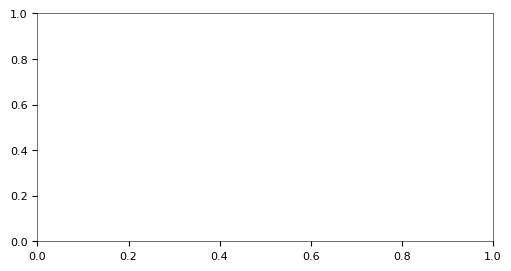

In [ ]:
companies.groupby(["CompanyCategory"]).size().reset_index(name='counts')


Can also look at where the companies are based in.

This is useful for looking at specific companies.

In [ ]:
search = companies[companies["CompanyNumber"] == "IP21991R"].dropna(axis='columns')
search

,Unnamed: 0,CompanyNumber,CompanyStatus,Accounts.AccountCategory,CompanyCategory,IncorporationDate,status
129438,129439,IP21991R,ACTIVE,NO ACCOUNTS FILED,Registered Society,01/01/1981,1


Another feature we can use is what type of accounts they have to upload to companies house. It's really interesting how only 95,000 companies have to upload full accounts to the website.

In [ ]:
count = companies.groupby("Accounts.AccountCategory")["Accounts.AccountCategory"].count()
print(count)

Accounts.AccountCategory
ACCOUNTS TYPE NOT AVAILABLE       927
AUDIT EXEMPTION SUBSIDIARY       4131
AUDITED ABRIDGED                  339
DORMANT                        141707
FILING EXEMPTION SUBSIDIARY        67
FULL                            20254
GROUP                            5232
INITIAL                             1
MEDIUM                             74
MICRO ENTITY                   336267
NO ACCOUNTS FILED              289944
PARTIAL EXEMPTION                   5
SMALL                           14853
TOTAL EXEMPTION FULL           256252
TOTAL EXEMPTION SMALL            2666
UNAUDITED ABRIDGED              34069
Name: Accounts.AccountCategory, dtype: int64


For this exercise I will build three time based features. First, how old the company is, second, how many years have passed since they last uploaded their accounts, and third how many years since they last uploaded their confirmation statement. Basic compliance metrics.

In [ ]:
gc.collect()

195

In [ ]:
from datetime import datetime, date

today = date.today()

companies['IncorporationDate'] = pd.to_datetime(companies['IncorporationDate'], errors = 'coerce')

companies['DissolutionDate']  = companies['DissolutionDate'].replace(np.nan,today)
companies['DissolutionDate'] = pd.to_datetime(companies['DissolutionDate'], errors = 'coerce')
companies


<ipython-input-11-2021c4283a8c>:8: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  companies['DissolutionDate'] = pd.to_datetime(companies['DissolutionDate'], errors = 'coerce')


,Unnamed: 0,CompanyNumber,CompanyStatus,SIC,Accounts.AccountCategory,CompanyCategory,RegAddress.PostCode,IncorporationDate,DissolutionDate,status
3,4,11743365,ACTIVE,C,DORMANT,Private Limited,EC1V 9LT,2018-12-28,2023-09-26,1
6,7,13522064,ACTIVE,J,MICRO ENTITY,Private Limited,WC2H 9JQ,2021-07-21,2023-09-26,1
8,9,SC606050,ACTIVE,L,TOTAL EXEMPTION FULL,Private Limited,AB11 7SY,2018-08-22,2023-09-26,1
10,11,09152972,ACTIVE,J,MICRO ENTITY,Private Limited,RH16 4RW,2014-07-30,2023-09-26,1
11,12,FC031362,ACTIVE,NaN,FULL,Other,GY1 1EW,2012-11-30,2023-09-26,1
...,...,...,...,...,...,...,...,...,...,...
7206223,7206224,13233860,DISSOLVED,G,NO ACCOUNTS FILED,Private Limited,PL21 0FB,2021-02-27,2021-06-15,0
7206224,7206225,13233878,DISSOLVED,C,NO ACCOUNTS FILED,Private Limited,HG1 4AA,2021-02-27,2021-01-06,0
7206354,7206355,13280444,DISSOLVED,J,NO ACCOUNTS FILED,Private Limited,N4 1HH,2021-03-21,2021-06-15,0
7206355,7206356,13284368,DISSOLVED,G,NO ACCOUNTS FILED,Private Limited,PO22 8BQ,2021-03-22,2021-06-15,0


In [ ]:
companies = companies.loc[(companies['IncorporationDate'] >= '1800-09-22')]

companies['age'] = companies['DissolutionDate'] - companies['IncorporationDate']
companies['age'] = companies['age'].dt.days
companies = companies.drop(columns=['Unnamed: 0'])

companies

<ipython-input-12-d4693917121a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  companies['age'] = companies['DissolutionDate'] - companies['IncorporationDate']
<ipython-input-12-d4693917121a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  companies['age'] = companies['age'].dt.days


,CompanyNumber,CompanyStatus,SIC,Accounts.AccountCategory,CompanyCategory,RegAddress.PostCode,IncorporationDate,DissolutionDate,status,age
3,11743365,ACTIVE,C,DORMANT,Private Limited,EC1V 9LT,2018-12-28,2023-09-26,1,1733
6,13522064,ACTIVE,J,MICRO ENTITY,Private Limited,WC2H 9JQ,2021-07-21,2023-09-26,1,797
8,SC606050,ACTIVE,L,TOTAL EXEMPTION FULL,Private Limited,AB11 7SY,2018-08-22,2023-09-26,1,1861
10,09152972,ACTIVE,J,MICRO ENTITY,Private Limited,RH16 4RW,2014-07-30,2023-09-26,1,3345
11,FC031362,ACTIVE,NaN,FULL,Other,GY1 1EW,2012-11-30,2023-09-26,1,3952
...,...,...,...,...,...,...,...,...,...,...
7206223,13233860,DISSOLVED,G,NO ACCOUNTS FILED,Private Limited,PL21 0FB,2021-02-27,2021-06-15,0,108
7206224,13233878,DISSOLVED,C,NO ACCOUNTS FILED,Private Limited,HG1 4AA,2021-02-27,2021-01-06,0,-52
7206354,13280444,DISSOLVED,J,NO ACCOUNTS FILED,Private Limited,N4 1HH,2021-03-21,2021-06-15,0,86
7206355,13284368,DISSOLVED,G,NO ACCOUNTS FILED,Private Limited,PO22 8BQ,2021-03-22,2021-06-15,0,85


In [ ]:
companies.head()

,CompanyNumber,CompanyStatus,SIC,Accounts.AccountCategory,CompanyCategory,RegAddress.PostCode,IncorporationDate,DissolutionDate,status,age
3,11743365,ACTIVE,C,DORMANT,Private Limited,EC1V 9LT,2018-12-28,2023-09-26,1,1733
6,13522064,ACTIVE,J,MICRO ENTITY,Private Limited,WC2H 9JQ,2021-07-21,2023-09-26,1,797
8,SC606050,ACTIVE,L,TOTAL EXEMPTION FULL,Private Limited,AB11 7SY,2018-08-22,2023-09-26,1,1861
10,09152972,ACTIVE,J,MICRO ENTITY,Private Limited,RH16 4RW,2014-07-30,2023-09-26,1,3345
11,FC031362,ACTIVE,NaN,FULL,Other,GY1 1EW,2012-11-30,2023-09-26,1,3952


Now I want to count how many companies are registered at the same postcode. The UK is notorious for having company formation farms, where a company offers individuals the option of registering a company with them and hiding their actual address. My logic is that companies registered at a unique postcode are more likely to be actual/succesful businesses.

https://www.1stformations.co.uk/

In [ ]:
import re
def clean_text(text):
    #text = text.astype(str)
    if pd.isnull(text):
      text = "UNKNOWN" # If we don't know where they are registered then replace with unknown.
    text = re.sub('[^A-Za-z0-9]+', '', text)
    if text.isnumeric():
      text = "FOREIGN" # If there is no alphabetical characters then replace as foreign.
    text = text.replace("\n","")
    text = text.strip()
    text = text.upper()
    return text
companies['postcode'] = companies["RegAddress.PostCode"].apply(lambda x: clean_text(x))

In [ ]:
shared_post = companies.groupby(["postcode"]).size().reset_index(name='shared_post')
shared_post.sort_values(by = "shared_post", ascending = False)


,postcode,shared_post
696848,WC2H9JQ,37268
677301,UNKNOWN,30089
407972,N17GU,28298
211102,EC1V2NX,26160
108194,CF148LH,12783
...,...,...
450425,NR135AF,1
450424,NR135AE,1
450423,NR135AD,1
186628,DN174HT,1


In [ ]:
age_data = companies.groupby(["age"]).size().reset_index(name='counts')
age_data["age"] = age_data.age.astype("float")
age_data.head()

,age,counts
0,-232.0,10
1,-229.0,3
2,-228.0,4
3,-227.0,4
4,-226.0,1


Let's visualize the proportion of active companies over time.



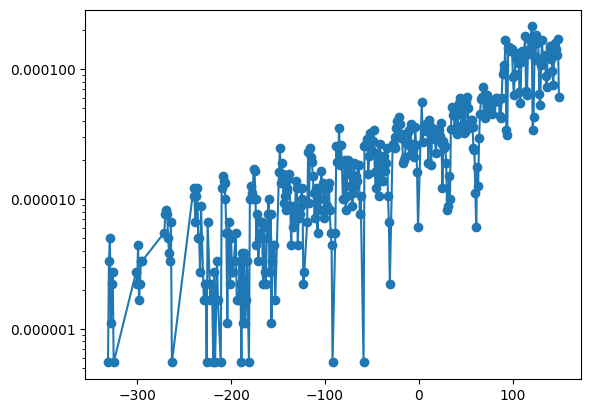

In [ ]:
age_data = companies.groupby(["age"]).size().reset_index(name='counts')
age_data["age"] = age_data.age.astype("float")
#age_data = age_data[(age_data["Age"] < 31)]
total_comps = age_data.counts.sum()
age_data['prop_age'] = age_data.counts/total_comps
age_data.head()
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter
sub_age = age_data[(age_data["age"] < 150)]
plt.scatter(sub_age.age, sub_age.prop_age)
plt.plot(sub_age.age, sub_age.prop_age)
plt.yscale("log")
ax = plt.gca()
ax.yaxis.set_major_formatter(ScalarFormatter())
plt.show()

There's some interesting binning in the proprtions ocurring after 40 years, where the slope stablizes for those companies.

In [ ]:
companies.info(memory_usage='deep')
gc.collect()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7206330 entries, 0 to 7206356
Data columns (total 11 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   CompanyNumber             object        
 1   CompanyStatus             object        
 2   SIC                       object        
 3   Accounts.AccountCategory  object        
 4   CompanyCategory           object        
 5   RegAddress.PostCode       object        
 6   IncorporationDate         datetime64[ns]
 7   DissolutionDate           datetime64[ns]
 8   status                    int64         
 9   age                       int64         
 10  postcode                  object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 3.3 GB


24339

Now reduce the dataframe to the columns we need for training the model.

In [ ]:
companies = companies.merge(shared_post, on='postcode', how='left')
companies = companies[['status','CompanyCategory', 'Accounts.AccountCategory', 'age',  "shared_post", "SIC"]]
companies

,status,CompanyCategory,Accounts.AccountCategory,age,shared_post,SIC
0,1,Private Limited,DORMANT,1733,119,C
1,1,Private Limited,MICRO ENTITY,797,37268,J
2,1,Private Limited,TOTAL EXEMPTION FULL,1861,3,L
3,1,Private Limited,MICRO ENTITY,3345,2,J
4,1,Other,FULL,3952,16,NaN
...,...,...,...,...,...,...
2861453,0,Private Limited,NO ACCOUNTS FILED,108,1,G
2861454,0,Private Limited,NO ACCOUNTS FILED,-52,2,C
2861455,0,Private Limited,NO ACCOUNTS FILED,86,1,J
2861456,0,Private Limited,NO ACCOUNTS FILED,85,4,G


In [ ]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import matplotlib.pylab as plt

Not much of a correlation between the engineered features...

<ipython-input-36-bcf7df7bc43e>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr=companies.corr()


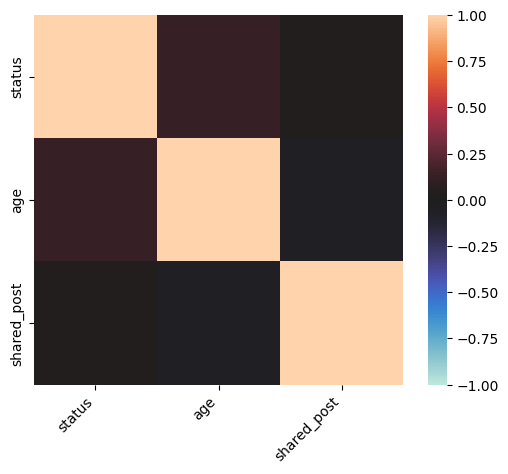

In [ ]:
corr=companies.corr()
ax = sns.heatmap(corr,
    vmin=-1, vmax=1, center=0,
    square=True)
ticks = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

Convert our categorical variables into dummies.

In [ ]:
import pandas as pd


companies = pd.get_dummies(companies, columns = ['CompanyCategory', 'Accounts.AccountCategory', "SIC"])
companies

,status,age,shared_post,CompanyCategory_Charitable Incorporated Organisation,CompanyCategory_Community Interest,CompanyCategory_Industrial and Provident Society,CompanyCategory_Investment with Variable Capital,CompanyCategory_Investment with Variable Capital (Securities),CompanyCategory_Investment with Variable Capital(Umbrella),CompanyCategory_Limited Liability Partnership,...,SIC_L,SIC_M,SIC_N,SIC_O,SIC_P,SIC_Q,SIC_R,SIC_S,SIC_T,SIC_U
0,1,1733,119,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,797,37268,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1861,3,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,1,3345,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,3952,16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2861453,0,108,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2861454,0,-52,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2861455,0,86,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2861456,0,85,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


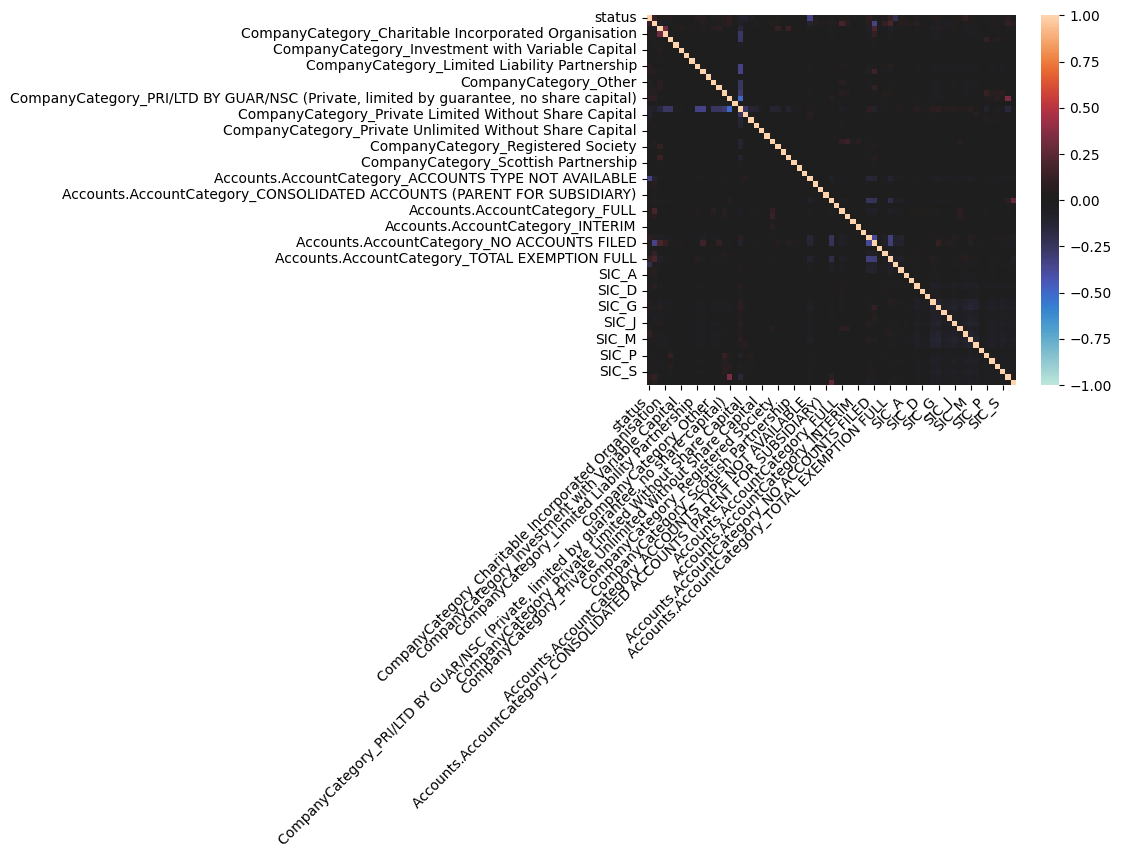

In [ ]:
corr=companies.corr()
ax = sns.heatmap(corr,
    vmin=-1, vmax=1, center=0,
    square=True)
ticks = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

Now let's split the data for the random forest.

In [ ]:
gc.collect()

83

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
columns = companies.columns.tolist()
y=companies[['status']]
X=companies[columns[1:-1]]
columns = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

Train on the random sample.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_features= 'auto')
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
score=metrics.accuracy_score(y_test, y_pred)
print(score)

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


0.8086326560566983


Not exactly great at predicting the unhealthy companies.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.67      0.69     89832
           1       0.85      0.87      0.86    196314

    accuracy                           0.81    286146
   macro avg       0.78      0.77      0.78    286146
weighted avg       0.81      0.81      0.81    286146



Confusion matrix:
 [[ 60540  29292]
 [ 25467 170847]]


<ipython-input-27-8aeae4f6eca9>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-27-8aeae4f6eca9>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


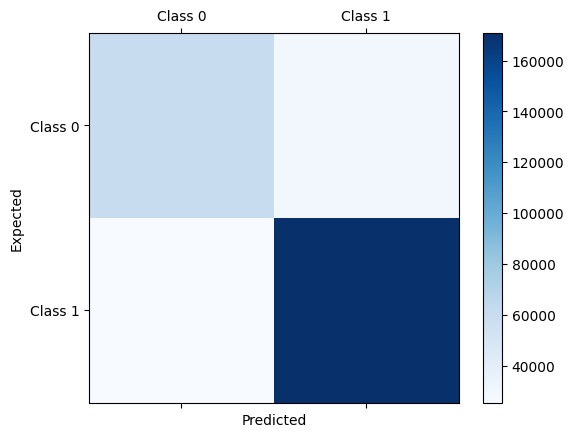

In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()


In [ ]:
gc.collect()

0

Let's try to downsample since the classes are so imbalanced.

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

SMOTE = SMOTE()
under = RandomUnderSampler(sampling_strategy='auto')


In [ ]:
columns = X_train.columns
X_train_under ,y_train_under=under.fit_resample(X_train, y_train)
X_train_under = pd.DataFrame(data=X_train_under,columns=columns )
y_train_under = pd.DataFrame(data=y_train_under,columns=['status'])

In [ ]:
clf_under = DecisionTreeClassifier(max_features= 'auto')
clf_under = clf_under.fit(X_train_under,y_train_under)
y_pred_under = clf_under.predict(X_test)
score=metrics.accuracy_score(y_test, y_pred_under)
print(score)

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


0.754758060570478


In [ ]:
print(classification_report(y_test, y_pred_under))


              precision    recall  f1-score   support

           0       0.58      0.75      0.66     89832
           1       0.87      0.75      0.81    196314

    accuracy                           0.75    286146
   macro avg       0.73      0.75      0.73    286146
weighted avg       0.78      0.75      0.76    286146



Confusion matrix:
 [[ 67770  22062]
 [ 48113 148201]]


<ipython-input-33-86eea3eef302>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-33-86eea3eef302>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


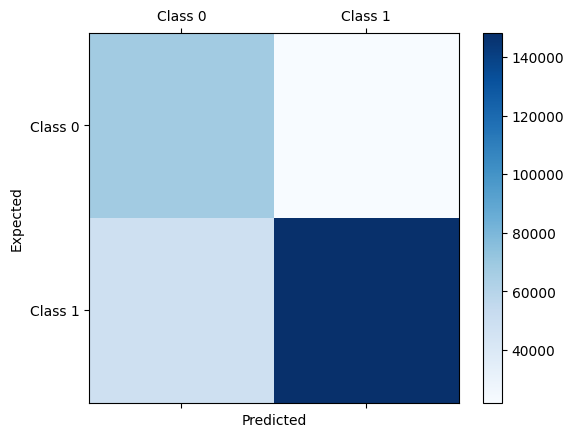

In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_under)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()